In [1]:
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import os
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch import nn
import torch.nn.functional as F
from torch.optim import Optimizer
from torch.optim.lr_scheduler import StepLR
import copy
from tqdm import tqdm
from torchviz import make_dot
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)





cuda:0


In [2]:

#load the data into torchvision.datasets
trainset = datasets.CIFAR10(root='./', train=True, download=False, transform=transforms.ToTensor())
batch_size = 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.CIFAR10(root='./', train=False, download=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# 10 classes in CIFAR-10
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [3]:
# Print the keys of the data
print(trainset.data.shape)
print(testset.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


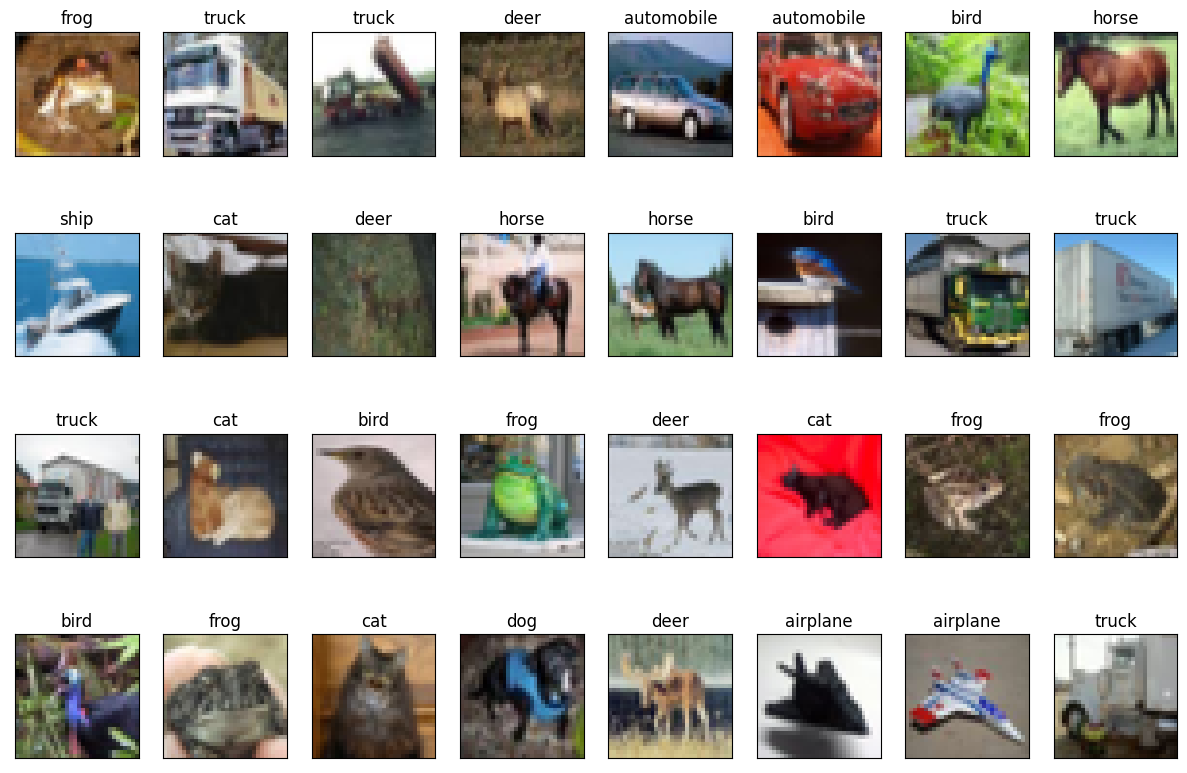

In [4]:
# Plot some images
plt.figure(figsize=(15,10))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainset.data[i])
    plt.title(class_names[trainset.targets[i]])





In [5]:
#import LeNet model
from LeNet import LeNet
lenet_model = LeNet().to(device)


In [6]:
#import ResNet model
from ResNet import ResNet
from ResNet import BasicBlock
resnet_model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

In [7]:
model = resnet_model
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): Dropout(p=0.3, inplace=False)
    (2): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm

In [8]:
# Define the loss function and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [9]:
# Train the model
num_epochs = 100   # Adjust the number of epochs as needed
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize best validation loss
epochs_no_improve = 0  # Counter for epochs without improvement

start_time = time.time() # Start time

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_correct_train = 0
    total_samples_train = 0
    epoch_loss_train = 0
    
    # Training loop
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Training)", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        total_correct_train += (outputs.argmax(1) == labels).sum().item()
        total_samples_train += labels.size(0)
        epoch_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    average_epoch_loss_train = epoch_loss_train / len(train_loader)
    train_loss_list.append(average_epoch_loss_train)
    train_acc = total_correct_train / total_samples_train * 100
    train_acc_list.append(train_acc)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    total_correct_val = 0
    total_samples_val = 0
    epoch_loss_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)", leave=False):
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            total_correct_val += (val_outputs.argmax(1) == val_labels).sum().item()
            total_samples_val += val_labels.size(0)
            epoch_loss_val += val_loss.item()

    average_epoch_loss_val = epoch_loss_val / len(test_loader)
    val_loss_list.append(average_epoch_loss_val)
    val_acc = total_correct_val / total_samples_val * 100
    val_acc_list.append(val_acc)

    print(f"Epoch [{str(epoch + 1).zfill(2)}/{str(num_epochs).zfill(2)}], Train Loss: {average_epoch_loss_train:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {average_epoch_loss_val:.4f}, Val Acc: {val_acc:.2f}%")
    # Early stopping check
    if average_epoch_loss_val < best_val_loss:
        best_val_loss = average_epoch_loss_val
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth') # Save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping!")
            break  # Exit loop
        
end_time = time.time()  # End time
minutes, seconds = divmod(end_time - start_time, 60)
print(f"Training time: {minutes} minutes {seconds:.2f} seconds")

Epoch 1/100 (Training):   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [01/100], Train Loss: 1.5275, Train Acc: 44.10%, Val Loss: 1.2962, Val Acc: 54.43%


Epoch [02/100], Train Loss: 1.0895, Train Acc: 61.20%, Val Loss: 1.0416, Val Acc: 64.53%


Epoch [03/100], Train Loss: 0.8923, Train Acc: 68.95%, Val Loss: 0.7634, Val Acc: 73.58%


Epoch [04/100], Train Loss: 0.7387, Train Acc: 74.40%, Val Loss: 0.6636, Val Acc: 77.29%


Epoch [05/100], Train Loss: 0.6446, Train Acc: 77.87%, Val Loss: 0.5690, Val Acc: 80.88%


Epoch [06/100], Train Loss: 0.5721, Train Acc: 80.24%, Val Loss: 0.5326, Val Acc: 81.84%


Epoch [07/100], Train Loss: 0.5098, Train Acc: 82.54%, Val Loss: 0.5070, Val Acc: 83.52%


Epoch [08/100], Train Loss: 0.4567, Train Acc: 84.35%, Val Loss: 0.4527, Val Acc: 84.97%


Epoch [09/100], Train Loss: 0.4146, Train Acc: 85.66%, Val Loss: 0.4079, Val Acc: 86.04%


Epoch [10/100], Train Loss: 0.3798, Train Acc: 86.95%, Val Loss: 0.4882, Val Acc: 83.79%


Epoch [11/100], Train Loss: 0.3377, Train Acc: 88.51%, Val Loss: 0.4278, Val Acc: 85.92%


Epoch [12/100], Train Loss: 0.3112, Train Acc: 89.46%, Val Loss: 0.4105, Val Acc: 86.32%


Epoch [13/100], Train Loss: 0.2809, Train Acc: 90.35%, Val Loss: 0.4264, Val Acc: 86.63%


Epoch [14/100], Train Loss: 0.2490, Train Acc: 91.41%, Val Loss: 0.4234, Val Acc: 87.11%


Epoch [15/100], Train Loss: 0.2334, Train Acc: 91.92%, Val Loss: 0.4091, Val Acc: 87.46%


Epoch [16/100], Train Loss: 0.2119, Train Acc: 92.60%, Val Loss: 0.4084, Val Acc: 87.85%


Epoch [17/100], Train Loss: 0.1891, Train Acc: 93.38%, Val Loss: 0.3886, Val Acc: 88.36%


Epoch [18/100], Train Loss: 0.1731, Train Acc: 93.96%, Val Loss: 0.4410, Val Acc: 87.50%


Epoch [19/100], Train Loss: 0.1583, Train Acc: 94.49%, Val Loss: 0.4163, Val Acc: 88.45%


Epoch [20/100], Train Loss: 0.1501, Train Acc: 94.73%, Val Loss: 0.4244, Val Acc: 87.95%


Epoch [21/100], Train Loss: 0.1378, Train Acc: 95.22%, Val Loss: 0.4515, Val Acc: 88.34%


Epoch [22/100], Train Loss: 0.1313, Train Acc: 95.38%, Val Loss: 0.4773, Val Acc: 87.39%


Epoch [23/100], Train Loss: 0.1200, Train Acc: 95.91%, Val Loss: 0.4270, Val Acc: 88.67%


Epoch [24/100], Train Loss: 0.1120, Train Acc: 96.16%, Val Loss: 0.4568, Val Acc: 88.51%


Epoch [25/100], Train Loss: 0.1087, Train Acc: 96.25%, Val Loss: 0.4837, Val Acc: 88.58%


Epoch [26/100], Train Loss: 0.1021, Train Acc: 96.47%, Val Loss: 0.4491, Val Acc: 88.49%


Epoch [27/100], Train Loss: 0.0953, Train Acc: 96.71%, Val Loss: 0.4725, Val Acc: 88.48%
Early stopping!
Training time: 39.0 minutes 49.85 seconds


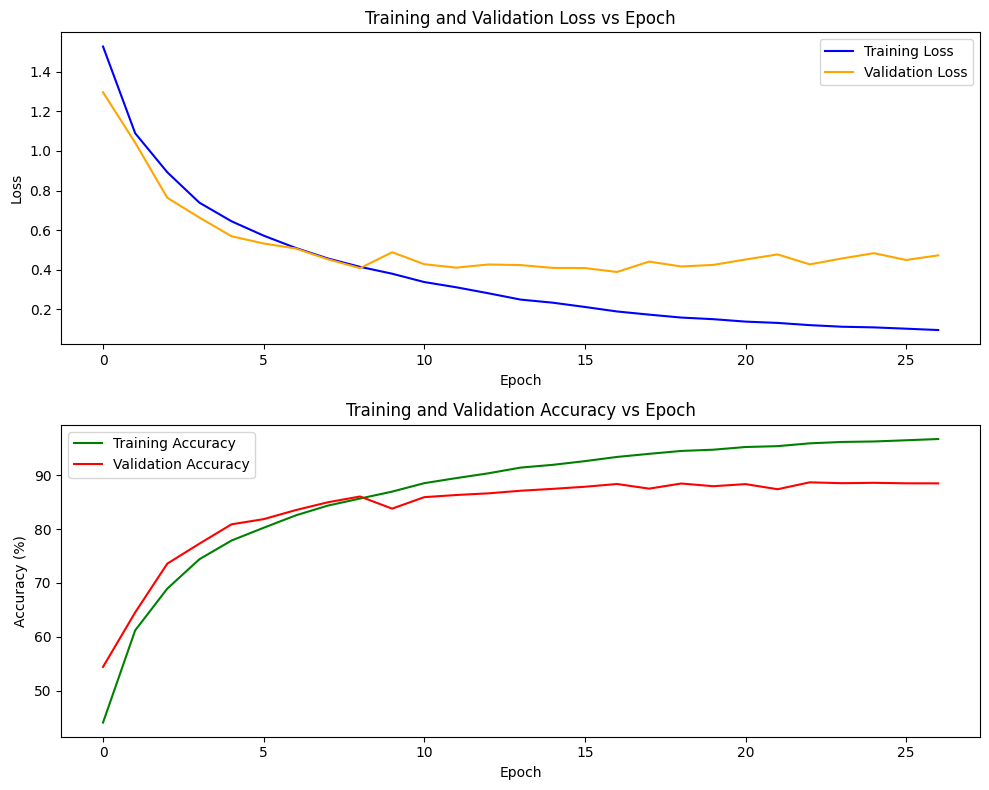

In [10]:
# Plot training and validation loss
plt.figure(figsize=(10, 8))

# Subplot 1: Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, label='Training Loss', color='blue')
plt.plot(val_loss_list, label='Validation Loss', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs Epoch")
plt.legend()

# Subplot 2: Training and Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(train_acc_list, label='Training Accuracy', color='green')
plt.plot(val_acc_list, label='Validation Accuracy', color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
# if model is already trained, load the model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [13]:
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Update lists
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Update Correct
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 88.36%


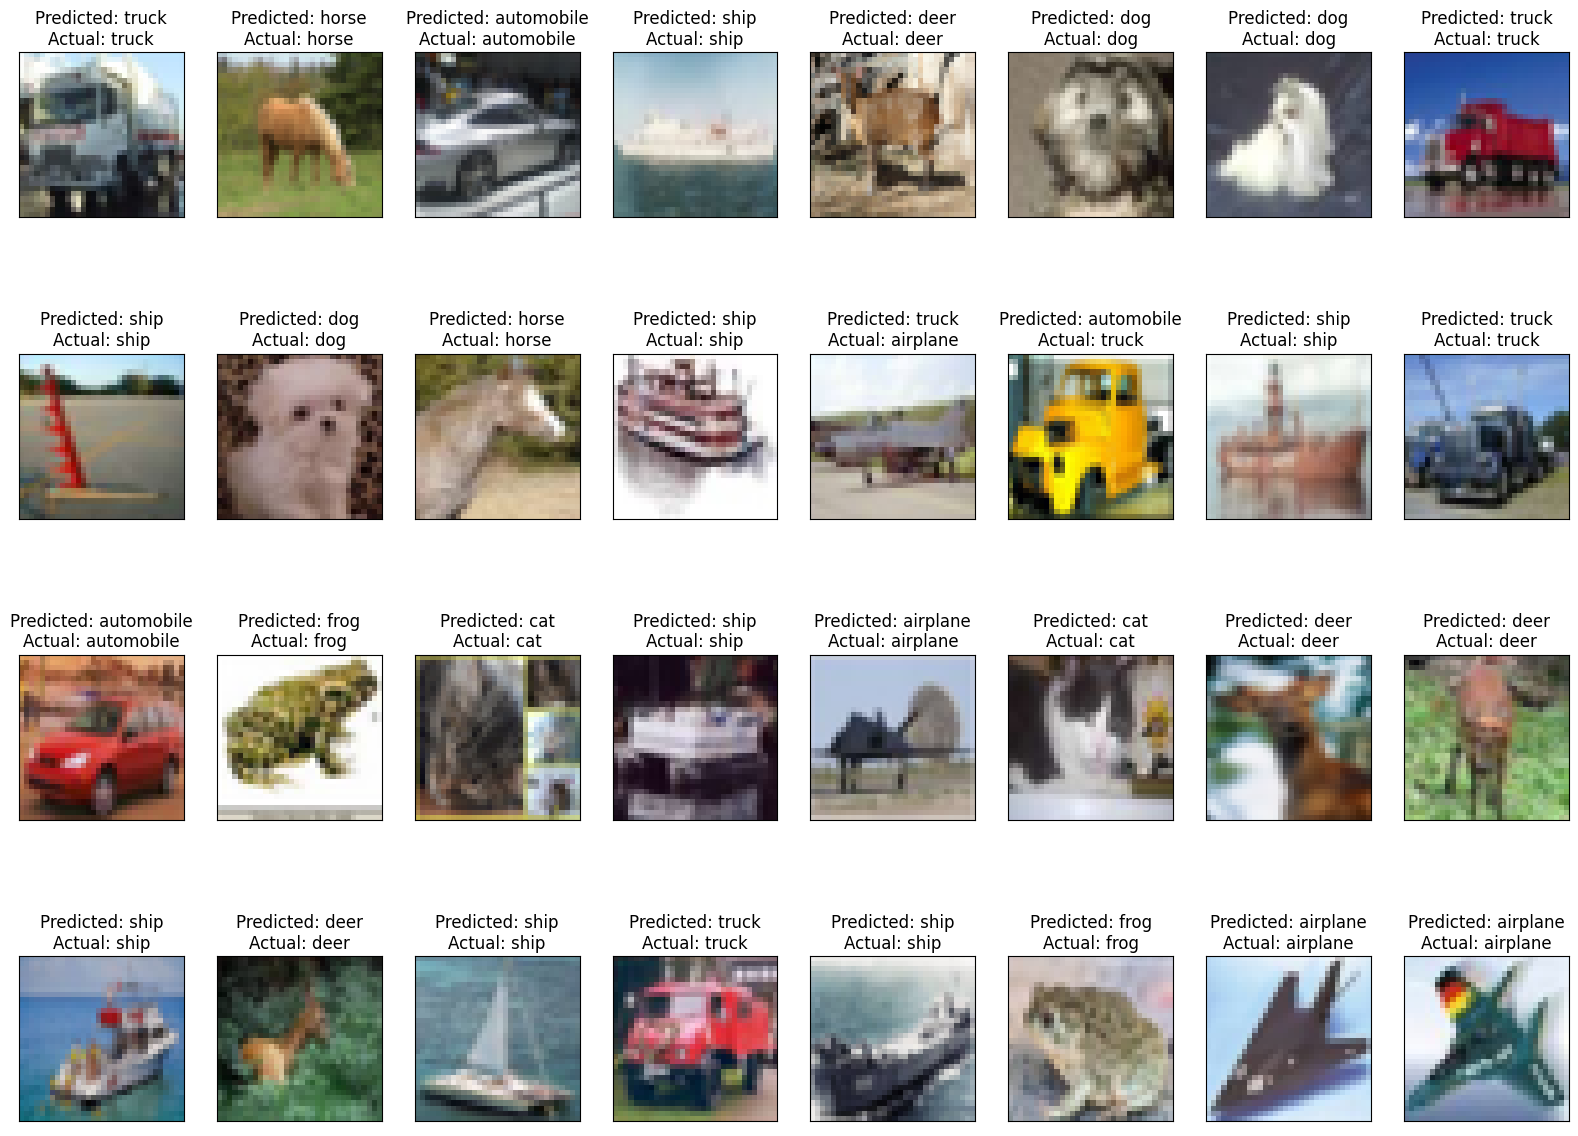

In [14]:
# Get a random batch from the test loader
random_batch_idx = random.randint(0, len(test_loader) - 1)
images, labels = list(test_loader)[random_batch_idx]

# Predict the labels
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Plot the images
fig = plt.figure(figsize=(20, 15))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
    plt.title(f'Predicted: {class_names[predicted[i]]}\nActual: {class_names[labels[i].item()]}')
    plt.xticks([])
    plt.yticks([])

plt.show()

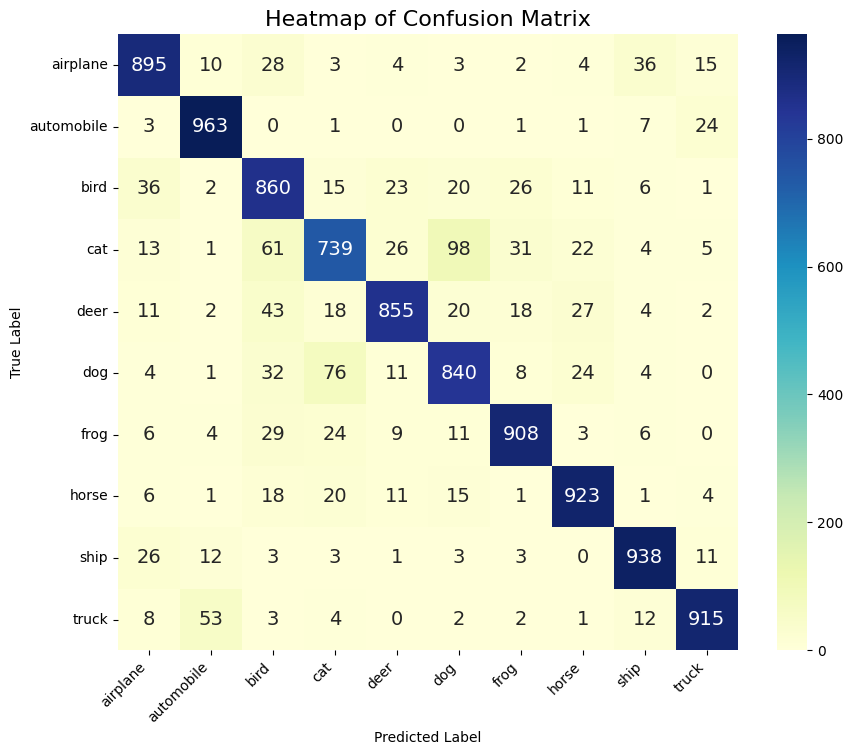

In [15]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=True, annot_kws={'size': 14},
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Heatmap of Confusion Matrix', fontsize=16)

# Adjust position of x-tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()
